In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

class PadWithin(nn.Module):
    """
        Pads the self-attention mask back to the original
        time frame
    """
    def __init__(self, stride=2):
        super(PadWithin, self).__init__()
        self.stride = stride
        
    def forward(self, feats):
        #print(feats.size(), self.stride)
        self.w = torch.zeros(self.stride, self.stride)
        self.w[0,0] = 1
        self.w = self.w.expand(1, 1, self.stride, self.stride)
        feats = feats.unsqueeze(1)
        stride = self.stride
        res = F.conv_transpose2d(feats, self.w, stride=self.stride, groups=feats.size(1)).squeeze(1)
        #print(res.size())
        return res

class Downsample(nn.Module):
    """
    Selects every nth element, where n is the index
    Based off of Fariseq implementation
    """

    def __init__(self, index):
        super(Downsample, self).__init__()
        self.index = index

    def forward(self, x):
        return x[:, :: self.index + 1, :]

def Linear(in_features, out_features, dropout=0.0, bias=True):
    """Weight-normalized Linear layer (input: B x T x C)"""
    m = nn.Linear(in_features, out_features, bias=bias)
    m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)


def GatedLinear(in_features, out_features, dropout=0.0, bias=True):
    """Weight-normalized Linear layer (input: B x T x C) with interspersed GLU units
        Fairseq implementation
    """
    return nn.Sequential(
        Linear(in_features, out_features * 4, dropout, bias),
        nn.GLU(),
        Linear(out_features * 2, out_features * 2, dropout, bias),
        nn.GLU(),
        Linear(out_features, out_features, dropout, bias),
    )

    
class GLU_conv(nn.Module):
    """
    Performs 2x convlutions with GLU activations and a linear output
    Input shape: (bs, seq_len, channels)
    Intermediate representation: (bs, channels, seq_len)
    Output shape: (bs, seq_len, channels)
    Author's implementation
    """
    def __init__(self, in_dim, out_dim, k=3, dropout=0.0, bias=True):
        super(GLU_conv,self).__init__()

        #for reshaping residual if necessary:
        self.convres1 = nn.utils.weight_norm(nn.Conv1d(in_dim, out_dim*2,
                                kernel_size=1),name='weight',dim=0)
        self.convres2 = nn.utils.weight_norm(nn.Conv1d(in_dim, out_dim,
                                kernel_size=1),name='weight',dim=0)

        #left padding to prevent future timesteps at current hidden state
        self.leftpad = nn.ConstantPad1d((k-1,0), 0)

        #shape (bs, in_dim, seq_len+(k-1))
        self.conv1a = nn.utils.weight_norm(nn.Conv1d(in_dim, out_dim*2,
                        kernel_size=1),name='weight', dim=0)
        self.conv1b = nn.utils.weight_norm(nn.Conv1d(in_dim, out_dim*2,
                        kernel_size=1),name='weight', dim=0)

        #shape (bs, out_dim*2, seq_len+(k-1))
        self.conv2a=nn.utils.weight_norm(nn.Conv1d(out_dim*2,out_dim*2,
                        kernel_size=k),name='weight',dim=0)
        self.conv2b=nn.utils.weight_norm(nn.Conv1d(out_dim*2,out_dim*2,
                        kernel_size=k),name='weight',dim=0)

        #shape (bs, out_dim*2, seq_len + k-1)
        self.conv3a=nn.utils.weight_norm(nn.Conv1d(out_dim*2,out_dim,
                        kernel_size=1),name='weight',dim=0)
        self.conv3b=nn.utils.weight_norm(nn.Conv1d(out_dim*2,out_dim,
                        kernel_size=1),name='weight',dim=0)
        
        #shape (bs, out_dim*2, seq_len + k-1) 
        self.conv4a=nn.utils.weight_norm(nn.Conv1d(out_dim,out_dim,
                        kernel_size=k),name='weight',dim=0)
        self.conv4b=nn.utils.weight_norm(nn.Conv1d(out_dim,out_dim,
                        kernel_size=k),name='weight',dim=0)

        #shape (bs, seq_len, out_dim)
        self.linear = Linear(out_dim, out_dim, dropout=dropout, bias=bias)
        #out shape (bs, out_dim, seq_len)

    def forward(self, X):
        X = X.permute(0,2,1)
        res1 = self.convres1(X)
        res2 = self.convres2(X)
        X=self.leftpad(X)
        #conv1 with GLU
        Xa = self.conv2a(self.conv1a(X))
        Xb = self.conv2b(self.conv1b(X))
        Xb = torch.sigmoid(Xb)
        X = torch.mul(Xa,Xb)
        X = X + res1
        X = self.leftpad(X)
        #conv2 with GLU
        Xa = self.conv4a(self.conv3a(X))
        Xb = self.conv4b(self.conv3b(X))
        Xb = torch.sigmoid(Xb)
        X = torch.mul(Xa,Xb)
        X = X + res2
        X = X.permute(0,2,1)
        return self.linear(X)

def Linear(in_features, out_features, dropout=0.0, bias=True):
    """Weight-normalized Linear layer (input: B x T x C)
        Fairseq implementation
    """
    m = nn.Linear(in_features, out_features, bias=bias)
    m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)


def GatedLinear(in_features, out_features, dropout=0.0, bias=True):
    """Weight-normalized Linear layer (input: B x T x C) with interspersed GLU units
        Fairseq implementation"""
    return nn.Sequential(
        Linear(in_features, out_features * 4, dropout, bias),
        nn.GLU(),
        Linear(out_features * 2, out_features * 2, dropout, bias),
        nn.GLU(),
        Linear(out_features, out_features, dropout, bias),
    )
    

class SingleAttention(nn.Module):
    """
        Modified from fairseq's original code to include unique padding and convolutional GLU layers
    """
    def __init__(self, out_channels, embed_dim, head_dim, downsample=True, head_index=0, dropout=0.0,
               bias=True, num_heads=1, conv_GLU=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout(dropout)
        self.head_index = head_index
        self.head_dim = head_dim
        self.num_heads = num_heads
        self.downsample = downsample
        
        if self.downsample:
            self.ds_layer = Downsample(self.head_index)
            self.pad_layer = PadWithin(self.head_index+1)
            out_size = self.head_dim
        else:
            out_size = self.head_dim * self.num_heads
        
        if conv_GLU:
            self.keys = GLU_conv(self.embed_dim, out_size, dropout=dropout, bias=bias)
            self.values = GLU_conv(self.embed_dim, out_size, dropout=dropout, bias=bias)
        else:
            self.keys = GatedLinear(self.embed_dim, out_size, dropout=dropout, bias=bias)
            self.values = GatedLinear(self.embed_dim, out_size, dropout=dropout, bias=bias)
            
        self.queries = GatedLinear(self.embed_dim, out_size, bias=bias)
        
        if self.downsample:
            self.out = Linear(out_size, self.head_dim, bias=bias)
        else:
            self.out = Linear(out_size, out_channels, bias=bias)
            
        self.scaling = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(p=dropout)
        
    def MaskedSelfAttention(self, query, key, tgt_len):
        src_len = key.size()[1]
        q = query
        k = key.permute(0,2,1)
        attn_weights = torch.bmm(q, k)
        attn_weights *= torch.tril(
            attn_weights.data.new([1]).expand(src_len,src_len).clone(),
            diagonal=-1).unsqueeze(0)
        attn_weights += torch.triu(
            attn_weights.data.new([-1000]).expand(src_len,src_len).clone(),
            diagonal=0).unsqueeze(0)
        
        attn_weights = F.softmax(attn_weights, dim=-1)
        if self.downsample and self.head_index > 0:
            attn_weights = self.pad_layer(attn_weights)
            attn_weights = attn_weights[:,:tgt_len, :tgt_len]
        return attn_weights
        
    def forward(self, k,v,q):
        batch_size, tgt_len, channels = k.size()
        """
        Scaled dot-product attention (Attention is all you need, Vaswani et. al):
        Compute bmm(Softmax(bmm(q,k^T)), v)
        """
        if self.downsample:
            k = self.ds_layer(k)
            q = self.ds_layer(q)
        q = self.queries(q)
        k = self.keys(k)
        v = self.values(v)
        q *= self.scaling
        
        #mask future timesteps
        if self.downsample:
            attn_weights = self.MaskedSelfAttention(q,k, tgt_len)
        else:
            attn_weights = torch.bmm(q,k.transpose(1,2))
            attn_weights = F.softmax(attn_weights, dim=-1)
        
        attn_weights = self.dropout(attn_weights)
        attn = torch.bmm(attn_weights, v)
        
        attn = self.out(attn)
        
        return attn, attn_weights

In [2]:
test = SingleAttention(300, 240, 240, True, 1, 0, True, 1, True)
t_ipt = torch.randn(32,32,240)
attn, attn_weight = test(t_ipt, t_ipt, t_ipt)
attn

torch.Size([32, 16, 16]) 2
torch.Size([32, 32, 32])


tensor([[[ 1.2580e-01,  1.1675e-02,  1.4133e-01,  ...,  1.5103e-01,
           7.6308e-02,  3.7534e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.6538e-01,  1.7438e-01, -1.3388e-01,  ...,  4.3016e-01,
           3.1990e-01, -6.4120e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2712e-01,  8.5855e-02,  2.0028e-01,  ...,  1.2024e-01,
           9.5388e-02,  1.2282e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 5.7519e-02,  2.5924e-01, -4.0612e-02,  ..., -5.4878e-04,
           2.1113e-01, -1.4226e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 5.2670e-01,  4.3375e-01, -3.4475e-01,  ..., -1.2243e-01,
           1.4003e-01, -3.0335e-01],
         ...,
         [ 0.0000e+00,  0

In [2]:
class MultiHeadAttention(nn.ModuleList):
    """
        Modified from fairseq's original implementation
    """
    def __init__(self,
                 out_channels,
                 embed_dim,
                 num_heads,
                 dropout=0.0,
                 bias=True,
                 downsample=True,
                 conv_GLU=True):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.downsample = downsample
        self.conv_GLU = conv_GLU
        assert self.head_dim * num_heads == embed_dim
        
        if self.downsample:
            attention_heads = []
            for index in range(num_heads):
                attention_heads.append(
                    SingleAttention(
                        out_channels, self.embed_dim, self.head_dim,
                        self.downsample, index, dropout, bias,
                        self.num_heads, self.conv_GLU 
                    )
                )
            super().__init__(modules=attention_heads)
            self.out = Linear(embed_dim, out_channels, dropout=dropout, bias=bias)
        else:
            super().__init__()
            self.attention_module = SingleAttention(
                out_channels, self.embed_dim, self.head_dim,
                self.downsample, 1, dropout, bias,
                self.num_heads, self.conv_GLU
            )

    def forward(self,k,v,q):
        attn_list = []
        attn_weight_list = []
        if self.downsample:
            for head_index in range(self.num_heads):
                attn, attn_weight = self[head_index](k,v,q)
                attn_list.append(attn)
                attn_weight_list.append(attn_weight)
            full_attn = torch.cat(attn_list, dim=2)
            full_attn = self.out(full_attn)
            return full_attn
        else:
            attn, attn_weight = self.attention(k,v,q)
            attn_list.append(attn)
            attn_weight_list.append(attn_weight_list)
            full_attn = torch.cat(attn_list, dim=2)
            return full_attn
        
class SelfAttention(nn.Module):
    def __init__(self, out_channels, embed_dim, num_heads, dropout=.1, bias=True, conv_GLU=True):
        super(SelfAttention, self).__init__()
        
        self.q = Linear(out_channels, embed_dim, dropout, bias)
        self.k = Linear(out_channels, embed_dim, dropout, bias)
        self.v = Linear(out_channels, embed_dim, dropout, bias)
        
        self.attention = MultiHeadAttention(out_channels, embed_dim, num_heads, dropout, bias,
                                            downsample=True, conv_GLU=conv_GLU)
        
        self.ln = nn.LayerNorm(out_channels)
        
    def forward(self, X):
        res = X
        
        q = self.q(X)
        k = self.k(X)
        v = self.v(X)
        X = self.attention(q,k,v)
        return self.ln(X+res)

In [4]:
test = SelfAttention(512, 240, 3)
t_ipt = torch.randn(32,30,512)
output = test(t_ipt)
output

torch.Size([32, 15, 15]) 2
torch.Size([32, 30, 30])
torch.Size([32, 10, 10]) 3
torch.Size([32, 30, 30])


tensor([[[-5.8472e-01,  4.9300e-01, -1.6401e+00,  ...,  1.4984e+00,
          -1.1279e+00, -1.1146e+00],
         [ 1.8893e+00, -1.5242e-01, -2.0919e+00,  ..., -1.5238e-01,
           1.7077e+00,  1.3987e+00],
         [-6.2167e-01,  4.3436e-01, -9.2484e-01,  ..., -1.2213e+00,
          -5.3314e-01,  1.3075e+00],
         ...,
         [ 2.2286e+00, -9.0162e-01, -8.2770e-01,  ..., -1.5605e+00,
          -1.3426e-01, -5.0758e-02],
         [-5.2931e-01, -5.7317e-01,  1.1349e-01,  ...,  6.9175e-01,
           1.2096e+00,  1.1798e-01],
         [ 9.3087e-01, -7.6999e-01,  5.9234e-01,  ...,  1.4715e+00,
          -1.5126e+00, -6.5029e-01]],

        [[-3.2521e-01,  8.0161e-01, -9.6093e-01,  ...,  2.9243e-01,
           3.9789e-01, -2.9876e-01],
         [ 1.9100e+00, -2.0307e+00,  7.0008e-01,  ..., -4.0184e-01,
           2.5776e+00,  3.8348e-01],
         [ 4.1236e-01, -1.0346e+00, -4.3023e-01,  ...,  4.4579e-01,
           7.0473e-01,  2.9084e-01],
         ...,
         [ 1.3077e-02, -4

In [3]:
class EncoderAttention(nn.Module):
    """
        Unique class for encoder attnetion
    """
    def __init__(self, out_channels, embed_dim, head_dim, head_index=0, dropout=0.0,
               bias=True, conv_GLU=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout(dropout)
        self.head_index = head_index
        self.head_dim = head_dim

        out_size = self.head_dim
        
        if conv_GLU:
            self.keys = GLU_conv(self.embed_dim, out_size, dropout=dropout, bias=bias)
            self.values = GLU_conv(self.embed_dim, out_size, dropout=dropout, bias=bias)
        else:
            self.keys = GatedLinear(self.embed_dim, out_size, dropout=dropout, bias=bias)
            self.values = GatedLinear(self.embed_dim, out_size, dropout=dropout, bias=bias)
            
        self.queries = GatedLinear(self.embed_dim, out_size, bias=bias)
        
        self.out = Linear(out_size, out_channels, bias=bias)
            
        self.scaling = self.head_dim ** -0.5
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        batch_size, src_len, channels = key.size()
        tgt_len = query.size(1)
        """
        Scaled dot-product attention (Attention is all you need, Vaswani et. al):
        Compute bmm(Softmax(bmm(q,k^T)), v).  Here the keys and values are from
        the encoder while the query is from the decoder.
        """
        q = self.queries(query)
        k = self.keys(key).permute(0,2,1)
        v = self.values(value)
        q *= self.scaling

        attn_weights = torch.bmm(q, k)      
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attn = torch.bmm(attn_weights, v)
        
        attn = self.out(attn)
        
        return attn, attn_weights

In [4]:
class GradMultiply(torch.autograd.Function):
    """
        Gradient scaling method from fairseq's code
    """
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        res = x.new(x)
        return res

    @staticmethod
    def backward(ctx, grad):
        return grad * ctx.scale, None

class Decoder(nn.Module):
    def __init__(
                    self,
                    in_dim,
                    vocab_size,
                    out_channels=512,
                    embed_dim=240,
                    num_heads=3,
                    max_len=1056,
                    num_layers=4,
                    dropout=.1,
                    conv_GLU=True
                ):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.dropout=dropout
        self.in_dim=in_dim
        self.num_heads=num_heads
        self.vocab_size = vocab_size
        
        self.fc1 = Linear(in_dim, embed_dim, dropout=dropout, bias=True)
        
        self.pad = nn.ModuleList()
        self.conv = nn.ModuleList()
        self.self_attention=nn.ModuleList()
        self.enc_attention=nn.ModuleList()    
        for i in range(num_layers):
            self.pad.append(nn.ConstantPad1d((4,0), 0))
            self.conv.append(nn.Conv1d(embed_dim, embed_dim, 5))
            self.enc_attention.append(EncoderAttention(embed_dim, embed_dim, embed_dim))
            self.self_attention.append(SelfAttention(embed_dim, embed_dim, num_heads))
        self.fc2 = Linear(embed_dim, out_channels, dropout=dropout, bias=True)
        self.fc3 = Linear(out_channels, vocab_size, dropout=dropout, bias=True)
        
        self.dropout_layer = nn.Dropout(p=dropout)
        
    def forward(self, X, encoder_outputs):
        encoder_a, encoder_b = encoder_outputs
        X = self.fc1(X)
        input_embed = X
        #avg_attn = None
        for pad, conv, attention, self_attention in zip(self.pad,
                                                        self.conv,
                                                        self.enc_attention,
                                                        self.self_attention):
            residual = X
            X = pad(X.transpose(1,2))
            X = conv(X).transpose(1,2)
            r=X
            X, _enc_att = attention(X+input_embed, encoder_a, encoder_b)
            X = X + r
            #For fusion models
            #if avg_attn == None:
                #avg_attn = _enc_att
            #else:
                #avg_attn.add_(_enc_att)
            X = self_attention(X)
            X = (X+residual) * math.sqrt(.5)
            
        X = self.fc2(X)
        X = self.dropout_layer(X)
        X = X[:,-1:,].squeeze(1)
        return self.fc3(X)

class Encoder(nn.Module):
    def __init__(self, in_dim, embed_dim=240, dropout=.1, num_layers=2, conv_GLU=True):
        super(Encoder,self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.dropout=dropout
        self.in_dim = in_dim
    
        self.fc1 = Linear(in_dim, embed_dim, dropout=dropout, bias=True)
        self.conv = nn.ModuleList()
        self.attention = nn.ModuleList()
        for i in range(num_layers):
            self.conv.append(nn.Conv1d(embed_dim, embed_dim, 5, padding=2))
            self.attention.append(SingleAttention(
                self.embed_dim, self.embed_dim, self.embed_dim,
                downsample=False, head_index=0, dropout=dropout,
               bias=True, num_heads=1, conv_GLU=conv_GLU)
            )
        self.fc2 = Linear(embed_dim, embed_dim, dropout=dropout, bias=True)
    
    def forward(self, X):
        X = self.fc1(X)
        input_embed = X
        
        for conv, attention in zip(self.conv, self.attention):
            residual = X
            X = conv(X.transpose(1,2)).transpose(1,2)
            X, _attn = attention(X,X,X)
            
            X = (X + residual) * math.sqrt(.5)
        
        X = self.fc2(X)
        
        X = GradMultiply.apply(X, 1.0 / (2.0 * self.num_layers))
        
        y = X + input_embed * math.sqrt(.5)
        
        return (X, y)

In [21]:
enc = Encoder(300)
test = torch.randn(32,16,300)
X, y = enc(test)
print(X.size(), y.size())

torch.Size([32, 16, 240]) torch.Size([32, 16, 240])


In [22]:
dec = Decoder(300, 347000)
test = torch.randn(32,16,300)
output = dec(test, (X,y))
output

tensor([[-0.9884, -0.3741,  1.9618,  ..., -0.4640,  0.3099, -0.1127],
        [ 0.9066,  1.3352,  2.2528,  ...,  0.9156, -0.2025,  0.0981],
        [ 1.1203,  1.0588,  0.9096,  ..., -0.8638, -0.5817,  0.5928],
        ...,
        [-0.9375, -0.1797,  1.3341,  ...,  0.2126,  0.2266, -1.6767],
        [ 0.4135,  0.9228, -0.3355,  ...,  0.2916,  0.4647,  1.0436],
        [ 0.8187, -1.1879,  0.6392,  ...,  1.8559,  1.0495, -0.5949]],
       grad_fn=<AddmmBackward>)

In [5]:
class StoryGenerator(nn.Module):
    def __init__(self, vocab_size, w2v_dim, embed_dim, prompt_len,
                 decoder_heads, decoder_layers, encoder_layers, out_channels,
                 dropout=.1, conv_GLU=True):
        super(StoryGenerator, self).__init__()
        self.vocab_size = vocab_size
        self.w2v_dim = w2v_dim
        self.embed_dim = embed_dim
        self.prompt_len = prompt_len
        self.num_heads = decoder_heads
        self.d_layers = decoder_layers
        self.e_layers = encoder_layers
        self.conv_GLU=conv_GLU
        self.out_channels = out_channels
        
        self.encoder = Encoder(w2v_dim, embed_dim, dropout=dropout,
                         num_layers=2, conv_GLU=conv_GLU)
        
        self.decoder = Decoder(w2v_dim, vocab_size, out_channels=self.out_channels, embed_dim=embed_dim,
                         num_heads = self.num_heads, max_len=1056, num_layers=self.d_layers,
                         dropout=dropout, conv_GLU=conv_GLU)
        
    def forward(self, prompt, prev_output):
        """
            tokens are of the form B X T X C
        """
        encoder_out = self.encoder(prompt)
        decoder_out = self.decoder(prev_output, encoder_out)
        return decoder_out

In [12]:
test = torch.randn(32,32,128)
enc = torch.randn(32,82, 128)
sg = StoryGenerator(len(wv.wv.vocab), wv.vector_size, 120,82,2,2,1,240)
eep = sg(enc, test)
print(eep.size())
print(eep[0])

torch.Size([32, 941319])
tensor([ 0.6118,  0.1297,  1.8189,  ..., -0.7337,  0.1020,  0.5867],
       grad_fn=<SelectBackward>)


In [98]:
test_enc =torch.randn(32,82,128).float()
test_dec = torch.randn(32,80,128).float()
sg(test_enc, test_dec).size()

torch.Size([32, 40, 40]) 2
torch.Size([32, 80, 80])
torch.Size([32, 27, 27]) 3
torch.Size([32, 81, 81])
torch.Size([32, 40, 40]) 2
torch.Size([32, 80, 80])
torch.Size([32, 27, 27]) 3
torch.Size([32, 81, 81])
torch.Size([32, 40, 40]) 2
torch.Size([32, 80, 80])
torch.Size([32, 27, 27]) 3
torch.Size([32, 81, 81])


torch.Size([32, 941319])

In [6]:
from gensim.models import KeyedVectors
from nltk import word_tokenize, sent_tokenize
wv = KeyedVectors.load("./embedding/ft_128.mdl", mmap='r')
print(len(wv.wv.vocab), wv.vector_size)

941319 128


In [7]:
wv.wv.vocab.get('test').index
vec = wv['test']
res = wv.similar_by_vector(vec)
res[0][0]

<ipython-input-7-155f8f41746c>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = wv['test']
<ipython-input-7-155f8f41746c>:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  res = wv.similar_by_vector(vec)


'test'

In [8]:
dev = torch.device('cpu')
dev2 = torch.device('cuda')
torch.cuda.device_count()

1

In [9]:
import numpy as np
from os import listdir
from os.path import join
ARRAY_DATA_DIR = './data/'
TEXT_DATA_DIR = './WritingPrompts/'
misspellings = {'*.*.*':'.',
               '*Stupid.*..': 'Stupid',
               'victor.\'..': 'victor',
               'have.*.5': 'have',
               '5.*Sigh..': 'Sigh',
               '*Riiing*ÔÇª.*Riiing*ÔÇª': 'ring',
               '.*IS*..':'is',
               '.*-..':'-',
               'found.\'..':'found',
               '*okay.*..':'okay'}
#mults = {'sanity..':['sanity', '..'],
        #'-Week':['-', 'Week'],
        #'2023-':['2023','-']}

def get_embedding_array(line, model):
    all_words = []
    words = word_tokenize(line)
    for word in words:
        if word in misspellings:
            word = misspellings[word]
        all_words.append(model[word][None,:])
    return np.concatenate(all_words, axis=0)

def get_prompt_story_arrays(model, prompts, stories, prompt_len,fold):
    lengths = []
    count = 0
    for prompt in prompts:
        prompt_name = f'{fold}/prompt_{count}.npy'
        story_name = f'{fold}/story_{count}.npy'
        p = get_embedding_array(prompt, model)
        pad = np.zeros((prompt_len - p.shape[0], model.wv.vector_size))
        p = np.concatenate([pad,p])
        try:
            story = stories.readline()
        except Exception as e:
            print('ran out of stories', e.strerror)
        try:
            s = get_embedding_array(story, model)
        except Exception as e:
            print(f'error loading {count}, {e}')
        #with open(join(ARRAY_DATA_DIR, prompt_name), 'wb') as f:
            #np.save(f,p)
        #with open(join(ARRAY_DATA_DIR, story_name), 'wb') as f:
            #np.save(f,s)
        #if count%1000==0:
            print(count)
        count += 1

def make_and_save_arrays(w2v, prompt_len):
    for fold in ['train', 'test', 'valid']:
        print(fold)
        prompt_name = fold + '.wp_source'
        story_name = fold + '.wp_target'
        target_name = fold + '.wp_predict'
        prompts = open(join(TEXT_DATA_DIR, prompt_name), 'r', encoding='cp850')
        stories = open(join(TEXT_DATA_DIR, story_name), 'r', encoding='cp850')
        get_prompt_story_arrays(w2v, prompts, stories, prompt_len, fold)
        prompts.close()
        stories.close()

In [10]:
class StoryDataset(torch.utils.data.IterableDataset):
    """
        Novel DataSet class to stream batches from file
        below has two implementations for make_data: one that returns a large batch of
        several hundred sequences per each file (story), and one that returns a single random
        sequence for each story
    """
    def __init__(self, fold, d_path, w2v, prompt_len, seq_len, start_point):
        pname = f'{fold}.wp_source'
        sname = f'{fold}.wp_target'
        self.p_path = join(d_path, pname)
        self.s_path = join(d_path, sname)
        self.fold = fold
        self.w2v = w2v
        self.prompt_len = prompt_len
        self.seq_len = seq_len
        self.start = start_point
        
    def get_embedding_array(self, line):
        all_words = []
        words = word_tokenize(line)
        for word in words:
            if word in misspellings:
                word = misspellings[word]
            try:
                all_words.append(self.w2v[word][None,:])
            except Exception as e:
                new_word = self.w2v.most_similar[word][0][0]
                all_words.append(self.w2v[new_word][None,:])
                print(f'error with {word}->{new_word}, {e}')
        return np.concatenate(all_words, axis=0)
        
    def make_prompt(self, line):
        p = self.get_embedding_array(line)
        pad = np.zeros((self.prompt_len - p.shape[0], self.w2v.wv.vector_size))
        return np.concatenate([pad,p])
        
    def make_story(self, line):
        return self.get_embedding_array(line)
        
    def make_data(self, p_line, s_line):
        p = self.make_prompt(p_line)
        s = self.make_story(s_line)
        i = np.random.randint(0, s.shape[0] - self.seq_len-1, 1)[0]
        seq = s[i:i+self.seq_len].copy()
        y = s[i+self.seq_len]
        res = self.w2v.similar_by_vector(y)[0][0]
        y = np.array([self.w2v.wv.vocab.get(res).index])
        seq = torch.tensor(seq).float()
        p = torch.tensor(p).float()
        y = torch.tensor(y).long()
        return p,seq,y
    
    def __iter__(self):
        self.seq_len = np.random.randint(20,100)
        print(self.seq_len)
        p_iter = open(self.p_path, 'r', encoding='cp850')
        s_iter = open(self.s_path, 'r', encoding='cp850')
        
        if self.start > 0:
            for i in range(self.start):
                p_iter.readline()
                s_iter.readline()
        
        tensor_iter = map(self.make_data, p_iter, s_iter)
        
        return tensor_iter
    
train_ds = StoryDataset('train', TEXT_DATA_DIR, wv, 82, 60, 0)
val_ds = StoryDataset('valid', TEXT_DATA_DIR, wv, 82, 60, 0)

In [11]:
trainLoader = torch.utils.data.DataLoader(train_ds, 32)
valLoader = torch.utils.data.DataLoader(val_ds, 32)

In [17]:
import time
import random

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

sg = StoryGenerator(
    len(wv.wv.vocab), wv.vector_size, 60, 82, 3, 3, 1, 120, conv_GLU=True
)
MODEL_PATH = './model/checkpoint_conv.pt'
model_parameters = filter(lambda p: p.requires_grad, sg.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
#sg.apply(init_weights)
sg.load_state_dict(torch.load(MODEL_PATH))
sg = sg.float()
sg.train()
#optimizer = torch.optim.SGD(sg.parameters(), lr=.0025, momentum=.90, nesterov=True)
loss_func = torch.nn.CrossEntropyLoss()
verbose = True
count = 15000
loss_hist = []
perp_hist = []
best_loss = 500
gradient = []
avg_grad = 2
no_improvement = 0
for e in range(10000):
    running_loss = 0
    running_perp = 0
    train_ds = StoryDataset('train', TEXT_DATA_DIR, wv, 82, 60, random.randint(0,210000))
    trainLoader = torch.utils.data.DataLoader(train_ds, 32)
    count = 0
    avg_grad = 2
    sg.train()
    sg.to(dev)
    t2 = time.time()
    for p, s, y in trainLoader:
        t1 = time.time()
        optimizer.zero_grad()
        pred = sg(p, s)
        loss = loss_func(pred, y.squeeze(1))
        loss.backward()
        #grad clipping
        nn.utils.clip_grad_norm_(sg.parameters(), avg_grad)
        optimizer.step()
        loss = loss.item()
        if math.isnan(loss):
            print('NAN', count)
            print(pred)
            break
        else:
            running_loss += loss
            running_perp += math.exp(loss)
        count+=1
        if count%100 == 0:
            torch.save(sg.state_dict(), MODEL_PATH)
            print(count, time.time() - t1)
            print(f'{loss}: {running_loss/count}')
    if count >= 5800:
        break
    loss_hist.append(loss)
    perp_hist.append(math.exp(loss))
    if verbose:
        print(f'{e}/10000--->Training Loss {running_loss/count}')
        print(f'------------>Training Perp {running_perp/count}')
        print(f'Time:{time.time() - t2}')
    #loss_hist.append(running_loss/count)
    #perp_hist.append(running_perp/count)

117201378
74


<ipython-input-10-6d523e72c02a>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  all_words.append(self.w2v[word][None,:])
<ipython-input-10-6d523e72c02a>:46: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  res = self.w2v.similar_by_vector(y)[0][0]


100 4.935732841491699
5.342617511749268: 5.4390601587295535
200 5.768805980682373
5.229543685913086: 5.441266555786132
300 5.288254737854004
5.1328959465026855: 5.434039136568705
400 5.421967029571533
5.331415176391602: 5.435452420711517


KeyboardInterrupt: 

In [49]:
#validation perplexity code
sg = StoryGenerator(
    len(wv.wv.vocab), wv.vector_size, 60, 82, 3, 3, 1, 120, conv_GLU=True
)
MODEL_PATH = './model/checkpoint_conv.pt'
#sg.apply(init_weights)
sg.load_state_dict(torch.load(MODEL_PATH))
sg = sg.float()
running_loss = 0
running_perp = 0
count = 0
sg.eval()
valLoader = torch.utils.data.DataLoader(val_ds, 32)
for p, s, y in valLoader:
    with torch.no_grad():
        pred = sg(p, s)
        loss = loss_func(pred, y.squeeze(1))
    running_loss += loss.item()
    running_perp += math.exp(loss.item())
    count +=1
    if count%1000 == 0:
        print(f'loss: {running_loss/count}')
        print(f'perp: {running_perp/count}')
val_loss = running_loss/count
val_perp = running_perp/count
if verbose:
    print(f'------>Val Loss {val_loss}')
    print(f'------->Val perp {val_perp}')

55


<ipython-input-44-38f986fa5400>:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  all_words.append(self.w2v[word][None,:])
<ipython-input-44-38f986fa5400>:46: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  res = self.w2v.similar_by_vector(y)[0][0]


------>Val Loss 5.856080358988912
------->Val perp 489.12493786023043


lin_perp = 765.2
conv_perp = 489.1
lin_its = 33231
conv_its = 42054

In [126]:
#from running above code with different settings from model
heads = [2.3, 2.4, 2.5, 2.6]
embed = [2.5, 3.3, 3.987, 4.715]
decoder = [2.1, 2.5, 2.7, 2.9]
encoder = [2.4, 2.4, 2.5, 2.7]
seq = [2.4, 2.41, 2.38, 2.5]
lin_dim = [2.1,2.9,3.84, 4.7]
lin_layer = [2.01, 2.176, 2.510, 2.602]

<IPython.core.display.Javascript object>


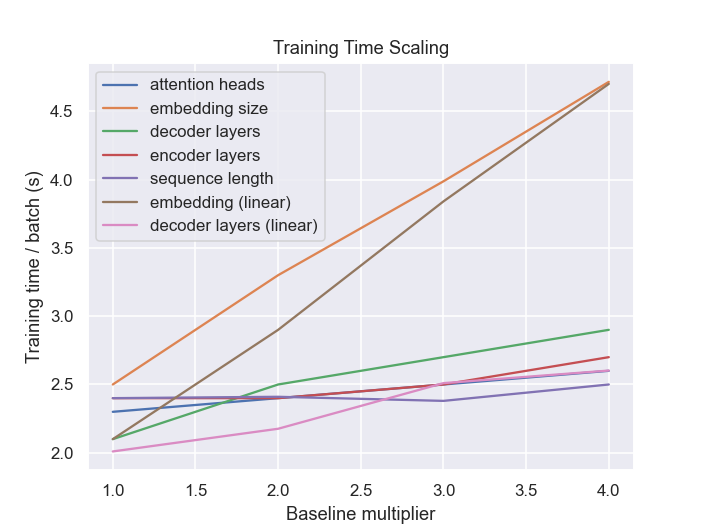

Text(0.5, 1.0, 'Training Time Scaling')

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
params = {'attention heads':heads,
         'embedding size':embed,
         'decoder layers':decoder,
         'encoder layers': encoder,
         'sequence length':seq,
         'embedding (linear)': lin_dim,
         'decoder layers (linear)':lin_layer}

plt.figure()
x = list(range(1,5))
for param, values in params.items():
    plt.plot(x, values, label=param)
plt.xlabel('Baseline multiplier')
plt.ylabel('Training time / batch (s)')
plt.legend()
plt.title('Training Time Scaling')  

<IPython.core.display.Javascript object>


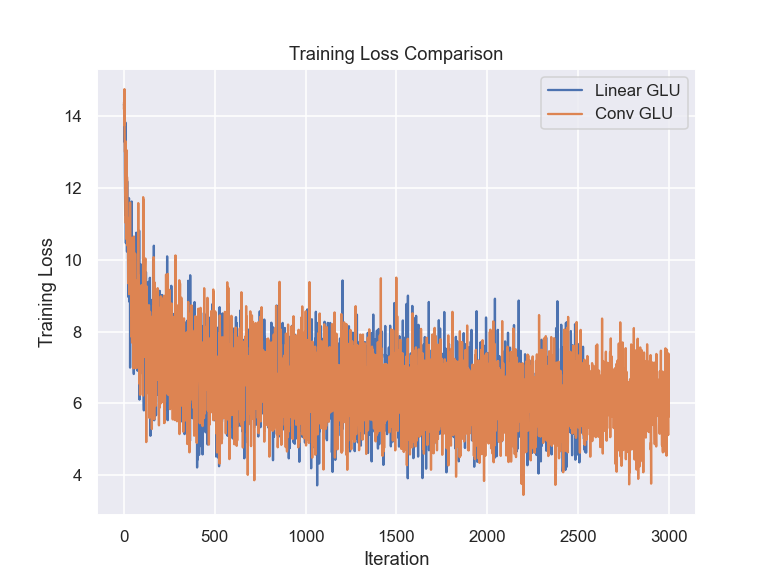

In [105]:
losses = {'Linear GLU':linear_hist,
         'Conv GLU':conv_hist}
%matplotlib notebook
plt.figure()
for loss, hist in losses.items():
    x = range(len(hist))
    plt.plot(x, hist, label = loss)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

    def make_data(self, p_line, s_line):
        p = self.make_prompt(p_line)[None,:,:]
        s = self.make_story(s_line)
        i = np.random.randint(0, s.shape[0] - self.seq_len-1, 1)[0]
        seq = s[i:i+self.seq_len].copy()[None,:,:]
        y = s[i+self.seq_len]
        res = self.w2v.similar_by_vector(y)[0][0]
        y = np.array([self.w2v.wv.vocab.get(res).index])[None,:]
        seq = torch.tensor(seq).float()
        p = torch.tensor(p).float()
        y = torch.tensor(y).long()
        return p,seq,y
    
    def make_data(self, p_line, s_line):
        P = []
        Y = []
        S = []
        p = self.make_prompt(p_line)
        s = self.make_story(s_line)
        for i in range(s.shape[0] - self.seq_len-1):
            seq = s[i:i+self.seq_len].copy()[None,:,:]
            y = s[i+self.seq_len]
            res = self.w2v.similar_by_vector(y)[0][0]
            y = np.array([self.w2v.wv.vocab.get(res).index])[None,:]
            P.append(p.copy()[None,])
            S.append(seq)
            Y.append(y)
        P = np.concatenate(P)
        Y = np.concatenate(Y)
        S = np.concatenate(S)
        P = torch.tensor(P).float()
        S = torch.tensor(S).float()
        Y = torch.tensor(Y).long().squeeze(-1)
        return P,S,Y